In [2]:
from comet_ml.api import API
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

comet_api = API(api_key="w7QuiECYXbNiOozveTpjc9uPg")
experiments = comet_api.get(workspace="onucharles", project_name="speech-model-compression")

def fetch_val_eer(experiments, cores_result_dict):
    for exp in experiments:
        tags = exp.get_tags()
        tag = tags[-1]
        
        if tag in cores_result_dict.keys():
            # best validation eer is the last one recorded.
            best_val_eer_dict = exp.get_metrics("best_eer")[-1]
            best_val_eer = float(best_val_eer_dict['metricValue'])
            # best_val_eer_step = int(best_val_eer_dict['step'])
            
            cores_result_dict[tag].append(best_val_eer)
    print(cores_result_dict)
    
    # average results of experiment repeats.
    cores_avg_result_dict = {}
    for tag, eer_list in cores_result_dict.items():
        print("Tag: {}. No of experiments: {}".format(tag, len(eer_list)))
        cores_avg_result_dict[tag] = round(np.mean(eer_list) * 100, 2) 
        
    return cores_avg_result_dict


def safely_get_parameter(api_exp, param_name):
    param_list = api_exp.get_parameters_summary(param_name)
    if len(param_list) == 0:
        raise ValueError("parameter '{}' was not found in experiment '{}'"
                         .format(param_name, api_exp.get_metadata()["experimentKey"]))
    return param_list["valueCurrent"]

def get_core_shape(n_cores):
    if n_cores == 2:
        shape = (16, 16)
    elif n_cores == 4:
        shape = (4, 4, 4, 4)
    elif n_cores == 8:
        shape = (2, 2, 2, 2, 2, 2, 2, 2)
    else:
        raise ValueError("cores value not supported.")
    return shape

ValueError: Invalid COMET_REST_API_KEY

# Model size and parameters

In [4]:
hidden_sizes = [24, 36, 256, 512, 768]
num_layers = [1, 2, 3]
input_size = 28 # 40
emb_size = 10 # 256

def lstm_num_params(num_layers, hidden_size, input_size, bias=True):
    n_gates_and_cell = 4
    result = 0
    
    # layer 1
    if bias:
        result = 4 * ((input_size + hidden_size + int(bias)) * hidden_size + hidden_size)
    else:
        result = 4 * ((input_size + hidden_size) * hidden_size)
    
    # for higher layers, input_size == hidden_size
    if num_layers > 1:
        num_layers_minus_1 = num_layers - 1
        if bias:
            result += num_layers_minus_1 * 4 * ((hidden_size + hidden_size + int(bias)) * hidden_size + hidden_size)
        else:
            result += num_layers_minus_1 * 4 * ((hidden_size + hidden_size) * hidden_size)
    
    return result

data = []
for hidden_size in hidden_sizes:
    row = []
    for layer_size in num_layers:
        num_linear_layer = ((hidden_size + 1) * emb_size)
        num_lstm_layers = lstm_num_params(layer_size, hidden_size, input_size)
        row.append(num_lstm_layers + num_linear_layer)
    data.append(row)
result = pd.DataFrame(data, index=hidden_sizes, columns=num_layers)
print("No of parameters")
print(result)


No of parameters
           1        2         3
24      5434    10234     15034
36      9874    20530     31186
256   295434   821770   1348106
512  1115146  3216394   5317642
768  2459146  7183882  11908618


# Evaluating no of parameters in linear layer using tensor-train.

In [7]:
cores_list = [(16,16), (4,4,4,4), (2,2,2,2,2,2,2,2)]
ranks_list = [2,4,6,8]

def tt_num_params(in_core_shape, out_core_shape, rank, bias=True):
    assert len(in_core_shape) == len(out_core_shape)
    n_cores = len(in_core_shape)
    
    result = 0
    out_size = 1
    for i in range(n_cores):
        if i == 0 or i == n_cores - 1:
            result += rank * (in_core_shape[i]) * out_core_shape[i]
        else:
            result += rank**2 * (in_core_shape[i]) * out_core_shape[i]
        out_size *= out_core_shape[i]
    
    if bias:
        result += out_size
    return result

tt_params_count = []
for core_shape in cores_list:
    row = []
    for rank in ranks_list:
        num_params = tt_num_params(core_shape, core_shape, rank, True)
        row.append(num_params)
    tt_params_count.append(row)
tt_df = pd.DataFrame(tt_params_count, index=cores_list, columns=ranks_list)
print("No of parameters (uncompressed):", 257 * 256)
print(tt_df)

No of parameters (uncompressed): 65792
                             2     4     6     8
(16, 16)                  1280  2304  3328  4352
(4, 4, 4, 4)               448   896  1600  2560
(2, 2, 2, 2, 2, 2, 2, 2)   368   672  1168  1856


# Evaluating no of parameters in TT-LSTM

In [10]:
hidden_size = 36
num_layers = 2
emb_size = 10
in_cores_list = [(4, 7), (2, 2, 7)]
hidden_cores_list = [(6, 6), (2, 3, 6)]
ranks_list = [1, 2, 3, 4, 5, 6, 7]

def tt_lstm_num_params(num_layers, hidden_core_shape, input_core_shape, rank, bias=True):
    n_gates_and_cell = 4
    result = 0
    
    # layer 1
    result = 4 * (tt_num_params(input_core_shape, hidden_core_shape, rank, bias) 
                      + tt_num_params(hidden_core_shape, hidden_core_shape, rank, bias))
    
    # for higher layers, input_size == hidden_size
    if num_layers > 1:
        num_layers_minus_1 = num_layers - 1
        result += num_layers_minus_1 * 4 * (tt_num_params(hidden_core_shape, hidden_core_shape, rank, bias) 
                      + tt_num_params(hidden_core_shape, hidden_core_shape, rank, bias))
    
    return result

data = []
for i in range(len(in_cores_list)):
    in_cores = in_cores_list[i]
    hidden_cores = hidden_cores_list[i]
    row = []
    for rank in ranks_list:
        num_linear_layer = ((hidden_size + 1) * emb_size)   # NOTE this is a dense matrix.
        num_lstm_layers = tt_lstm_num_params(num_layers, hidden_cores, in_cores, rank, True)
        row.append(num_lstm_layers + num_linear_layer)
    data.append(row)
result = pd.DataFrame(data, index=in_cores_list, columns=ranks_list)
print("No of parameters")
print(result)


No of parameters
              1     2     3     4     5     6      7
(4, 7)     2074  3202  4330  5458  6586  7714   8842
(2, 2, 7)  1742  2802  4126  5714  7566  9682  12062


# parameters using concatenation trick


# Evaluating no of parameters in linear layer using low-rank factorisation.

In [41]:
def low_rank_params(in_features, out_features, rank, bias):
    return ((in_features + int(bias)) * rank) + ((rank + int(bias)) * out_features)

in_size = 256
out_size = 256
ranks = 2 ** np.arange(1,7)

print("No of parameters (uncompressed):", 256 * 256)
print("Rank\tNum of Parms")
for rank in ranks:
    print("{}\t{}".format(rank, low_rank_params(in_size, out_size, rank, True)))

No of parameters (uncompressed): 65536
Rank	Num of Parms
2	1282
4	2308
8	4360
16	8464
32	16672
64	33088


# Plot experiment result

In [36]:
# dict with "key: n-cores", "value: dict of (key: rank, value: test_eer)"
experiments_result_dict = {2: {2: 0, 4: 0, 6: 0, 8: 0},
                          4: {2: 0, 4: 0, 6: 0, 8: 0},
                          8: {2: 0, 4: 0, 6: 0, 8: 0}}
exp_seed = 11

for exp in experiments:    
    use_tt = exp.get_parameters_summary("use_tt")["valueCurrent"]
    if not use_tt: continue
    
    try:
        n_cores = int(safely_get_parameter(exp, "n_cores"))
        tt_rank = int(safely_get_parameter(exp, "tt_rank"))
        seed = int(safely_get_parameter(exp, "seed"))
        best_val_eer = float(exp.get_metrics("best_eer")[-1]['metricValue'])
    except Exception as e:
        print(e)
        continue

    if n_cores not in experiments_result_dict \
            or tt_rank not in experiments_result_dict[n_cores] \
                or seed != exp_seed:
        print("Skipping experiment: use_tt={}, n_cores={}, tt_rank={}, seed={}".format(use_tt, n_cores, tt_rank, seed))
        continue
    experiments_result_dict[n_cores][tt_rank] = best_val_eer
print(experiments_result_dict)
        

parameter 'seed' was not found in experiment '64d984142c0748f0b824de7425bb34d9'
parameter 'seed' was not found in experiment '23a34c802d9a4d9ea2ae65b781bec2d2'
parameter 'seed' was not found in experiment 'ad68d1c6fe4c4d84b20c3dc5728545b8'
parameter 'seed' was not found in experiment 'ee3c3d8429fc4edd8ccf37c6dc51709f'
parameter 'seed' was not found in experiment '7195a9d84e7e4f01a7cbe1c88ed55ac5'
parameter 'seed' was not found in experiment '25ead0112a5446d4a74093b858d7c0ef'
parameter 'seed' was not found in experiment 'f370c270097d4b0d9655529c8ad144e0'
parameter 'seed' was not found in experiment 'b12b7300047149d6aa7372bb7b706af6'
parameter 'seed' was not found in experiment '74b35859efef4e89854f78047a7cc1bf'
parameter 'seed' was not found in experiment 'daa314a8ec10421394501fb26f6e7d02'
parameter 'seed' was not found in experiment '0ddad14e05864c85ae84ed56422db7ad'
parameter 'seed' was not found in experiment '437f3bb799684b8fa8be56fd87774741'
parameter 'seed' was not found in experi

LR params:  [4360, 8464, 16672, 33088]
TT-2cores params: [1280, 2304, 3328, 4352]
TT-4cores params: [448, 896, 1600, 2560]
TT-8cores params: [368, 672, 1168, 1856]


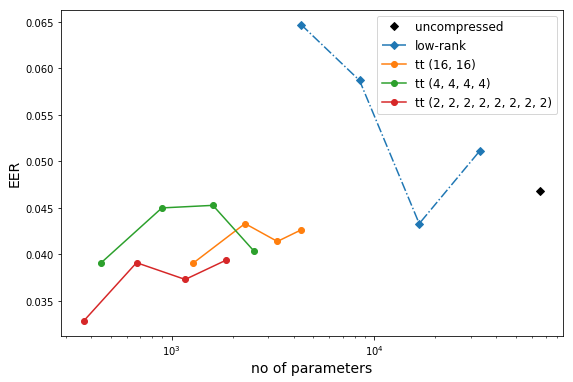

In [56]:
plt.figure(figsize=(9, 6))
in_size = 256
out_size = 256

# plot uncompressed experiment.
plt.plot((in_size+1)*out_size, 0.0468, "D", label="uncompressed", color='black', linewidth=3)

# plot low-rank experiments
lr_param_counts = [low_rank_params(in_size, out_size, rank, True) for rank in [8, 16, 32, 64]]
print("LR params: ", lr_param_counts)
plt.plot(lr_param_counts, [.0647, 0.0587, 0.0433, 0.0511], "-.D", label="low-rank")

# plot tt experiments.
for k, v in experiments_result_dict.items():
    # get no of params for each rank
    core_shape = get_core_shape(k)
    param_counts = [tt_num_params(core_shape, core_shape, rank, True) for rank in v.keys()]
    print("TT-{}cores params: {}".format(len(core_shape), param_counts))
    plt.plot(param_counts, v.values(), "-o", label="tt " + str(core_shape))
plt.xscale('log')
plt.xlabel('no of parameters', fontsize=14)
plt.ylabel('EER', fontsize=14)
plt.legend(fontsize=12)
plt.show()

{'tt-cores4-rank2': [0.04134615384757199, 0.04238782051446542, 0.03906250000000022, 0.03906250000009872, 0.039583333334543266], 'tt-cores4-rank3': [0.03914262820514222, 0.04062500000000007], 'tt-cores4-rank4': [0.042187500000000024, 0.044991987178826826, 0.04658830275229364], 'tt-cores4-rank5': [0.04062500000000005, 0.04519230769182035, 0.039022943037974725], 'tt-cores4-rank6': [0.0452681107954545, 0.04311277932960928, 0.03906250000000891], 'tt-cores4-rank8': [0.04687500000000031, 0.0403125, 0.039062499999996725]}
Tag: tt-cores4-rank2. No of experiments: 5
Tag: tt-cores4-rank3. No of experiments: 2
Tag: tt-cores4-rank4. No of experiments: 3
Tag: tt-cores4-rank5. No of experiments: 3
Tag: tt-cores4-rank6. No of experiments: 3
Tag: tt-cores4-rank8. No of experiments: 3


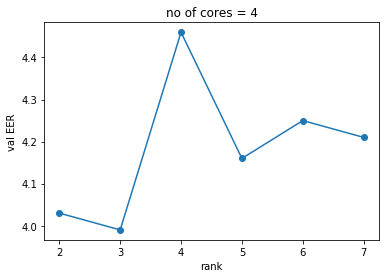

In [78]:
# plot the val EER for each rank.
ranks_result_dict = {'tt-cores4-rank2':[], 'tt-cores4-rank3':[], 'tt-cores4-rank4':[], 'tt-cores4-rank5':[], 
                     'tt-cores4-rank6':[], 'tt-cores4-rank8':[]}
ranks_avg_result_dict = fetch_val_eer(experiments, ranks_result_dict)
plt.figure()
plt.plot(np.arange(2,8), ranks_avg_result_dict.values(), '-o')
plt.xlabel('rank')
plt.ylabel('val EER')
plt.title('no of cores = 4')
plt.show()

# Visualising saved spectograms.

In [3]:
frame_fpath = r'D:\Users\Charley\Documents\Esperanza\repos\_experiments\speech-model-compression\speaker-verification\_librispeech_train-clean-100_tisv\LibriSpeech_train-clean-100_103\1240_103-1240-0000.npy'
frame_fpath = r'D:\Users\Charley\Documents\Esperanza\repos\_experiments\speech-model-compression\speaker-verification\_librispeech_train-clean-100_tisv\LibriSpeech_train-clean-100_1183\128659_1183-128659-0000.npy'
frames = np.load(frame_fpath).transpose()
frames.shape
plt.stem(y)
plt.show()

# import librosa
# import IPython.display as ipd
# wav_path = '777-126732-0006.wav'
# y, sr = librosa.load(wav_path)
# D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
# librosa.display.specshow(D, y_axis='linear')
# plt.colorbar(format='%+2.0f dB')

NameError: name 'y' is not defined